In [0]:
"""
This notebook calculates the image reconstruction under the Poisson noise with
the same intensity before the reaching the mask!!!
In this case, the total number of photons is 1e6 and the DMD will block part of
them.

Remember: from 1e-2 or 1e-1 second
also set the pre-mask intensity 
""";

In [2]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";
os.chdir(path);
os.listdir(path);

Mounted at /content/drive


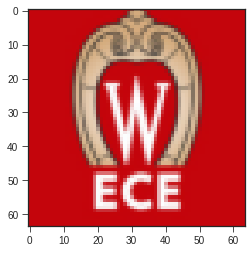

In [3]:
import numpy as np;
import matplotlib.pyplot as plt;
plt.style.use('seaborn-ticks')

#plt.style.use('classic');
#plt.rcParams['figure.figsize'] = [4,3];

import matplotlib.image as mpimg;

from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;
from YZ_masks import Haar_2d, Hyper_raster;

r = 64;
c = 64;

#########################################################
ratio_val = 0. ## to determine how many 1s in the masks!
Pnoise = True;
Gnoise = False;

Voxtel_camera = 25 * 256**2; ## the photon number per second for Vextel camera is 400
#########################################################

error = [];

pmt = CSP();
pmt.Load_img("ECE.jpg",RGB = True, size = (r,c), anti_aliasing = False);  

In [0]:
n_ph_per_sec = 1e6;

maximum_time = 100;
data_density = 7;
time = (np.arange(data_density)+1)/data_density*maximum_time;
time = [1e-2, 1e-1,1e-0] + list(time);

Error_raster_local = np.zeros(len(time));
Error_raster_global = np.zeros(len(time));
Error_basis = np.zeros(len(time));
Error_cs = np.zeros(len(time));
Error_hr =  np.zeros(len(time)); #hyper resolution
Error_hr2 =  np.zeros(len(time)); #hyper raster
Error_hr_Haar = np.zeros(len(time));
Error_voxtel= np.zeros(len(time));

In [5]:
## initialize the DMD masks for the four measure strategy!
_,_,layers = pmt.img.shape;
raster_cycles = r * c;
pmt.Make_DMD_basis(raster_cycles, scan_mode='Raster');
mask_raster = pmt.DMD_basis;
measure_raster_local = np.zeros((raster_cycles, layers, len(time)));
measure_raster_global = np.zeros((raster_cycles, layers, len(time)));

basis_cycles = r * c;
#pmt.Make_DMD_basis(basis_cycles, scan_mode="Basis", ratio = ratio_val);
#pmt.Make_DMD_basis(basis_cycles, scan_mode="Random", ratio = 0);
#mask_basis = pmt.DMD_basis;
mask_basis = np.ceil(pmt.DCT_Matrix(r*c));
measure_basis = np.zeros((basis_cycles, layers, len(time)));

hr_cycles = int(r*c * 0.3);
pmt.Make_DMD_basis(hr_cycles, scan_mode ="Basis", ratio = ratio_val);
mask_hr = pmt.DMD_basis;
measure_hr = np.zeros((hr_cycles, layers, len(time)));
threshold = 1-np.mean(mask_hr);

# The ratio of 1 in cs masks (if we use random) should be determined by hr masks
cs_cycles = int(r*c * 0.3);
#pmt.Make_DMD_basis(cs_cycles, scan_mode ="Random", ratio = ratio_val);
raw_cs_mask = np.random.rand(cs_cycles, r*c);
mask_cs = np.ceil(raw_cs_mask - threshold);
print("The mean of HR mask is %.3e\nThe mean of CS mask is %.3e"%(np.mean(mask_hr), np.mean(mask_cs)));
#mask_cs = pmt.DMD_basis;
#pmt.Make_DMD_basis(r * c, scan_mode ="Basis", ratio = ratio_val);
#selection = np.random.permutation(r*c)[:cs_cycles];
#mask_cs = pmt.DMD_basis[selection];
measure_cs = np.zeros((cs_cycles, layers, len(time)));


#hr2_cycles = int(r*c * 0.3); ## using hyper raster method (lower resolution)
mask_hr2 = Hyper_raster(r,c, 0.3);
hr2_cycles = len(mask_hr2);
measure_hr2 = np.zeros((hr2_cycles, layers, len(time)));

## test if we use a camera
measure_voxtel = np.zeros((raster_cycles, layers, len(time)));

The mean of HR mask is 5.004e-01
The mean of CS mask is 5.004e-01


In [6]:
"""
This part: before mask constant intensity (Aperture constant)
"""
## make measurement tensors!
## the variable "factor" is used to offset the brightness. for example:
## you can only have 1e7 photons, and you measure 1e4 cycles, so each mask will
## have 1e3 photons. if all the chips open, each pixel will have only 1e3 / (r*c)
## photons. but if you only have half of chips open, each pixel can be 2 times 
## brighter. The fewer chips open, the brighter each pixel can be. That is meaning
## of "factor".
for time_index in range(len(time)):  
    #print("%s/%s"%(time_index+1, len(time)));

    pmt.YZ_process_bar((time_index+1)/len(time), theme = False);

    time_ep = time[time_index];
    n_ph_tot = time_ep * n_ph_per_sec;

    ## Voxtel camera:
    light_level_voxtel = Voxtel_camera * time_ep/(r*c);
    for layer in range(layers):
        img_vector = np.reshape(pmt.img_tensor[:,:,layer], (r*c,));
        measure_voxtel[:,layer,time_index] = pmt.Poisson_noise(img_vector * light_level_voxtel ) / light_level_voxtel
    #measure_voxtel[:,:,time_index] = pmt.Poisson_noise(pmt.img_tensor[:,:,0] * light_level_voxtel) / light_level_voxtel;



    ## raster_scan
    #light_level_raster_local = n_ph_tot / raster_cycles;
    factor = r*c;
    light_level_raster_local = Voxtel_camera * time_ep / raster_cycles / factor;
    #light_level_raster_local = Voxtel_camera * time_ep / raster_cycles;
    measure_raster_local[:,:,time_index] = pmt.PMT_measure_simu(light_level_raster_local, raster_cycles, 
                                               Poisson = Pnoise, Gaussian = Gnoise,
                                               upload_DMD_basis=mask_raster);
    '''print("The average measured intensity is %.3e for raster local" 
          %np.mean(measure_raster_local[:,:,time_index]))'''

    #factor = np.sum(mask_raster) / (r*c)**2;
    #light_level_raster_global = n_ph_tot / raster_cycles / (r*c);
    light_level_raster_global = n_ph_tot / raster_cycles / (r*c);
    
    measure_raster_global[:,:,time_index] = pmt.PMT_measure_simu(light_level_raster_global, raster_cycles, 
                                               Poisson = Pnoise, Gaussian = Gnoise,
                                               upload_DMD_basis=mask_raster);
    '''print("The average measured intensity is %.3e for raster global" 
          %np.mean(measure_raster_global[:,:,time_index]))'''
    
    ## Basis_scan
    #factor = np.sum(mask_basis) / (r*c)**2;
    light_level_basis = n_ph_tot / basis_cycles / (r*c);
    #light_level_basis = n_ph_tot / raster_cycles / (r*c) / factor;
    #light_level_basis = n_ph_tot / np.sum(mask_basis);
    measure_basis[:,:,time_index] = pmt.PMT_measure_simu(light_level_basis, basis_cycles,
                                        Poisson = Pnoise, Gaussian = Gnoise,
                                        upload_DMD_basis=mask_basis);
    '''print("The average measured intensity is %.3e for basis scan" 
          %np.mean(measure_basis[:,:,time_index]))'''
                                        
    ## CS
    #factor = np.sum(mask_cs) / (r*c)**2;
    light_level_cs = n_ph_tot / cs_cycles / (r*c);
    #light_level_cs = n_ph_tot / cs_cycles / (r*c) / factor;
    #light_level_cs = n_ph_tot / np.sum(mask_cs)
    measure_cs[:,:,time_index] = pmt.PMT_measure_simu(light_level_cs, cs_cycles, 
                                     Poisson = Pnoise, Gaussian = Gnoise,
                                     upload_DMD_basis=mask_cs);
    '''print("The average measured intensity is %.3e for CS" 
          %np.mean(measure_cs[:,:,time_index]))'''
    ## HR
    #factor = np.sum(mask_hr) / (r*c)**2;
    light_level_hr = n_ph_tot / hr_cycles / (r*c);
    #light_level_hr = n_ph_tot / hr_cycles / (r*c) / factor;
    #light_level_hr = n_ph_tot / np.sum(mask_hr)
    measure_hr[:,:, time_index] =  pmt.PMT_measure_simu(light_level_hr, hr_cycles, 
                                     Poisson = Pnoise, Gaussian = Gnoise,
                                     upload_DMD_basis=mask_hr);
    '''print("The average measured intensity is %.3e for hyper reso" 
          %np.mean(measure_hr[:,:,time_index]))'''                                 

    ## HR2 hyper raster
    #light_level_hr2 = Voxtel_camera*time_ep/hr2_cycles / (r*c) /(np.sum(mask_hr2) /(r*c)/hr2_cycles);
    light_level_hr2 = light_level_raster_local;
    ## total number of photons / pixels per image
    measure_hr2[:,:, time_index] =  pmt.PMT_measure_simu(light_level_hr2, hr2_cycles, 
                                     Poisson = Pnoise, Gaussian = Gnoise,
                                     upload_DMD_basis=mask_hr2);
    '''print("The average measured intensity is %.3e for hyper raster" 
          %np.mean(measure_hr2[:,:,time_index]))'''

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

In [7]:
print("Raster local: The photons per mask per pixel is %s"%(light_level_raster_local));
print("Raster global: The photons per mask per pixel is %s"%(light_level_raster_global));
print("Basis scan: The photons per mask per pixel is %s"%(light_level_basis));
print("CS: The photons per mask per pixel for is %s"%(light_level_cs));
print("Hyper reso: The photons per mask per pixel for is %s"%(light_level_hr));
print("Hyper raster: The photons per mask per pixel for  is %s"%(light_level_hr2));

Raster local: The photons per mask per pixel is 9.765625
Raster global: The photons per mask per pixel is 5.9604644775390625
Basis scan: The photons per mask per pixel is 5.9604644775390625
CS: The photons per mask per pixel for is 19.88115838762215
Hyper reso: The photons per mask per pixel for is 19.88115838762215
Hyper raster: The photons per mask per pixel for  is 9.765625


In [0]:
## raster_reconstruct
raster_inv = mask_raster;
#basis_inv = np.linalg.pinv(mask_basis);
M = mask_basis.dot(mask_basis.T);
regularization = 1e-3;
M += regularization * np.eye(M.shape[0], M.shape[1]);
basis_inv = mask_basis.T.dot(np.linalg.pinv(M));

0 / 10


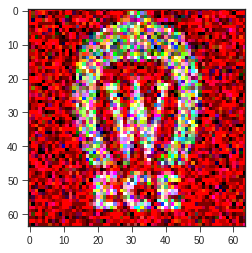

1 / 10


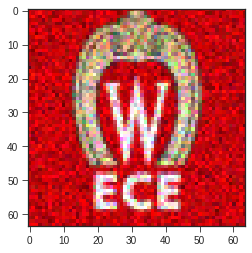

2 / 10


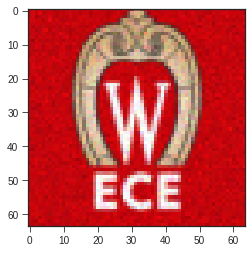

3 / 10


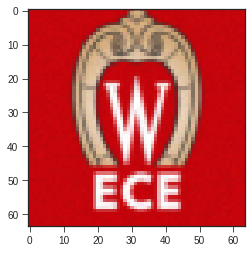

4 / 10


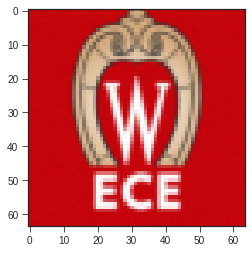

5 / 10


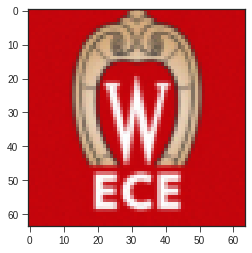

6 / 10


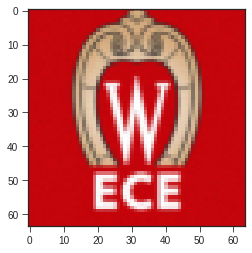

7 / 10


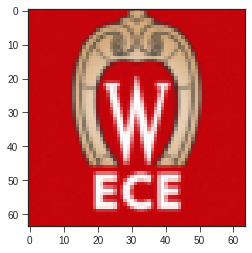

8 / 10


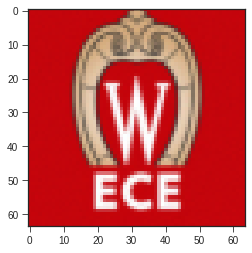

9 / 10


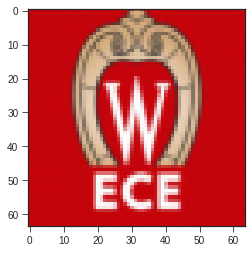

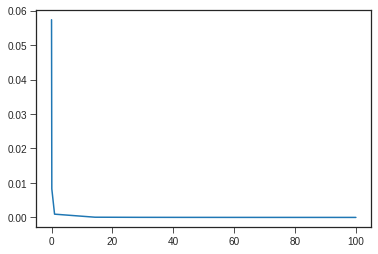

In [9]:
## voxtel recon
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    recons = np.zeros((r,c,layers));
    for layer in range(layers):
        recons[:,:,layer] = np.reshape(measure_voxtel[:,layer, time_index],(r,c));
    recons_clipped = np.clip(recons, a_min = 0, a_max = 1);
    plt.figure();
    plt.imshow(recons_clipped);
    plt.show();
    this_error = (np.mean((recons_clipped - pmt.img)**2));

    Error_voxtel[time_index] = this_error;
plt.figure();
plt.plot(time, Error_voxtel);
plt.show();


0 / 10


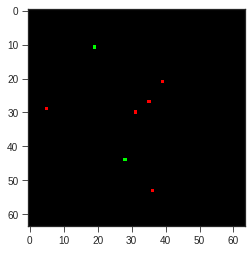

1 / 10


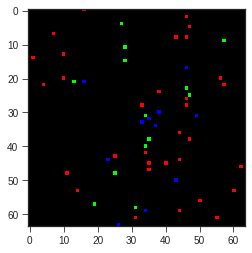

2 / 10


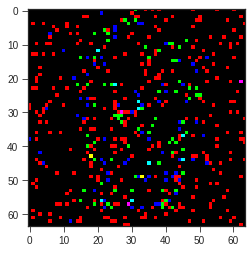

3 / 10


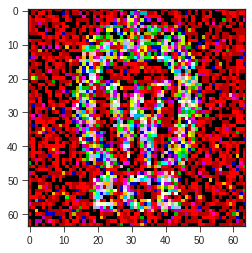

4 / 10


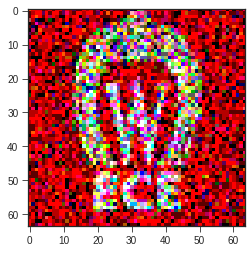

5 / 10


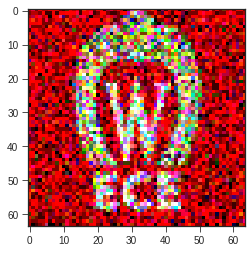

6 / 10


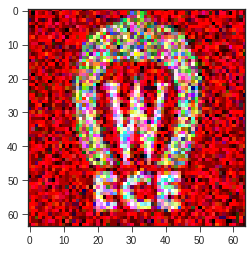

7 / 10


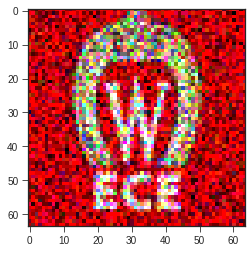

8 / 10


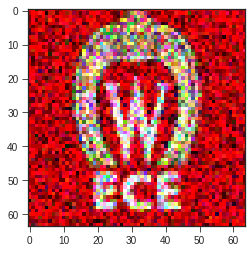

9 / 10


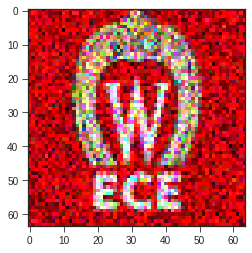

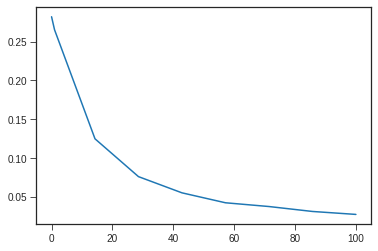

In [10]:
## raster local recon
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_direct_inverse_reconstruction(r, c, raster_inv, measure_raster_local[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    
    Error_raster_local[time_index] = this_error;
plt.figure();
plt.plot(time, Error_raster_local);
plt.show();

0 / 10


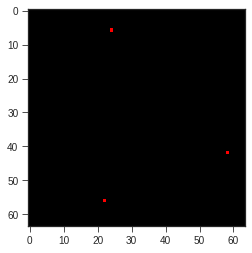

1 / 10


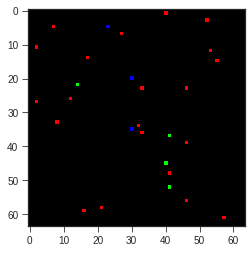

2 / 10


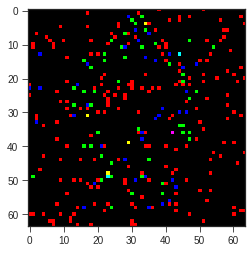

3 / 10


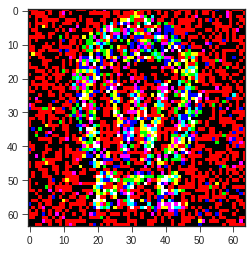

4 / 10


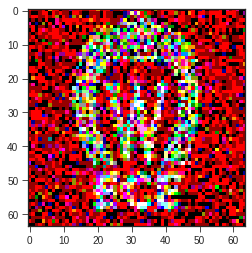

5 / 10


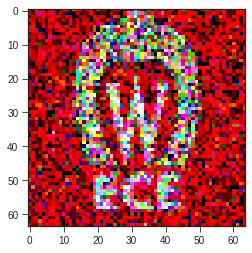

6 / 10


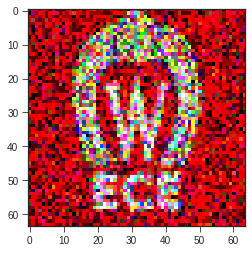

7 / 10


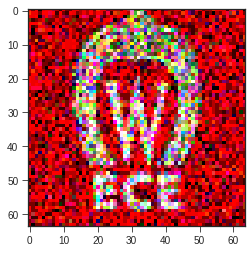

8 / 10


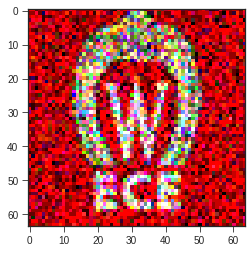

9 / 10


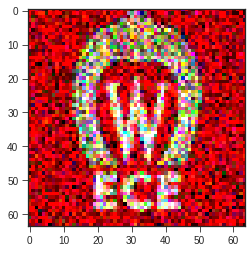

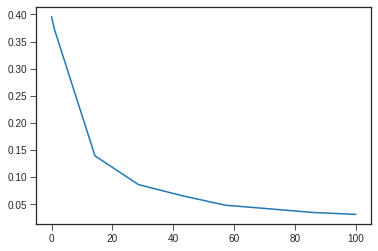

In [11]:
## raster global recon
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_direct_inverse_reconstruction(r, c, raster_inv, measure_raster_global[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img))**2)**0.5;
    
    Error_raster_global[time_index] = this_error;
    
plt.figure();
plt.plot(time, Error_raster_global);
plt.show();

0 / 10


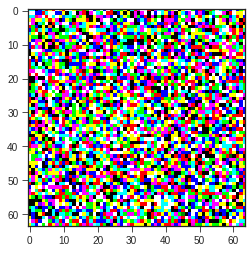

1 / 10


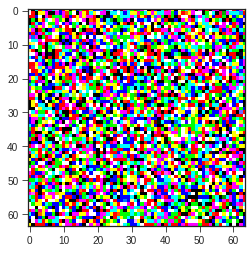

2 / 10


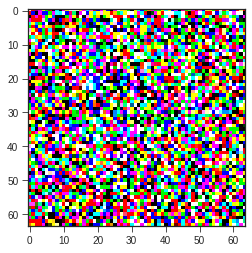

3 / 10


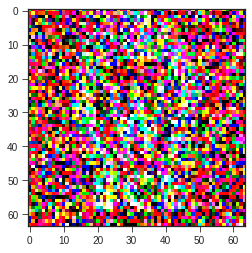

4 / 10


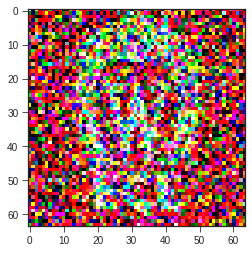

5 / 10


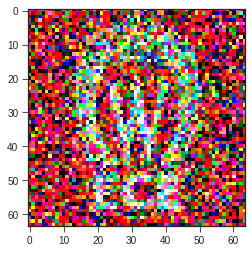

6 / 10


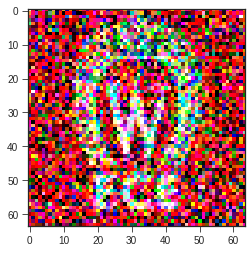

7 / 10


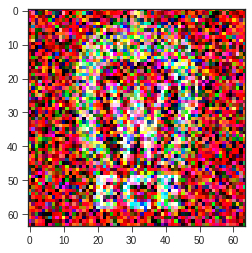

8 / 10


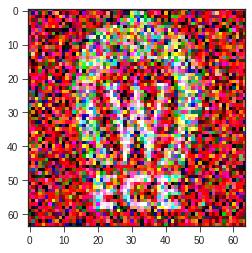

9 / 10


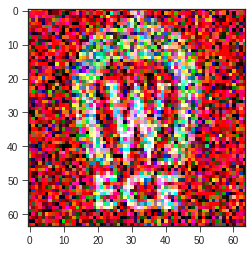

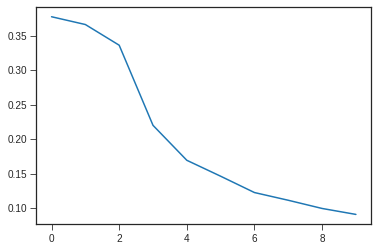

In [12]:
## basis recon
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_direct_inverse_reconstruction(r, c, basis_inv, measure_basis[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    Error_basis[time_index] = this_error;

plt.figure();
plt.plot(Error_basis);
plt.show();

0 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 4.044e+06} |··················································| 0.0%
{cost = 3.032e+01} |>>>>>>>>>>········································| 20.0%
{cost = 5.485e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.712e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.518e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.988e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

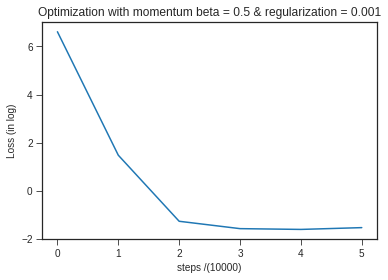

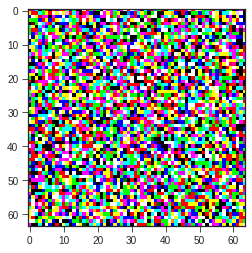

1 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.964e+06} |··················································| 0.0%
{cost = 3.720e+00} |>>>>>>>>>>········································| 20.0%
{cost = 3.156e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 4.706e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.740e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.673e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

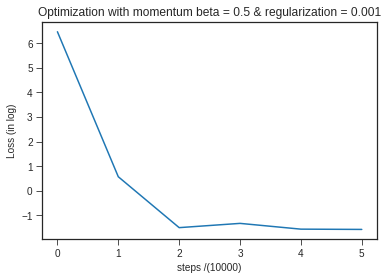

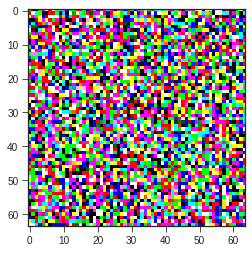

2 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.867e+06} |··················································| 0.0%
{cost = 3.693e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.166e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.507e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.117e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.794e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

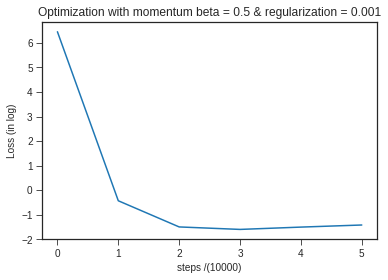

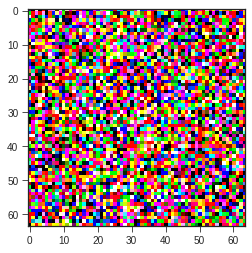

3 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.851e+06} |··················································| 0.0%
{cost = 8.218e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.500e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.382e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.109e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.638e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

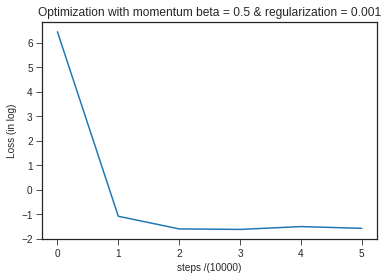

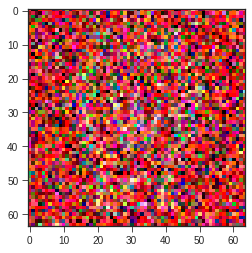

4 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 6.502e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.655e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.514e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.878e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.207e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

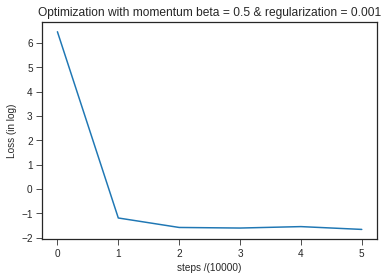

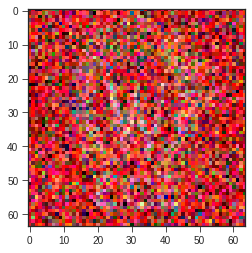

5 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.846e+06} |··················································| 0.0%
{cost = 5.031e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.811e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.301e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.181e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.594e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

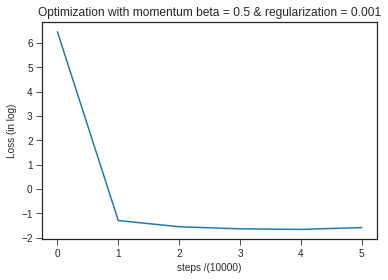

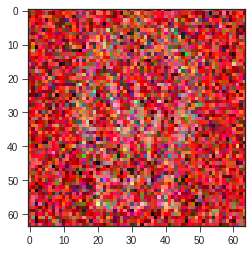

6 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.848e+06} |··················································| 0.0%
{cost = 5.422e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.629e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.248e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.149e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.229e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

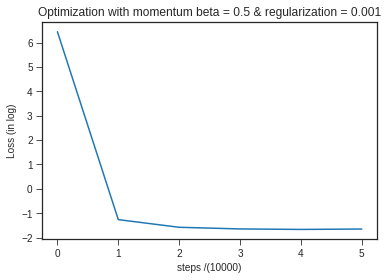

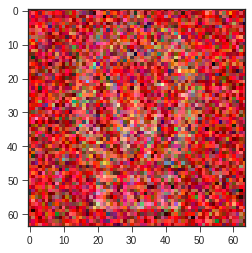

7 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.845e+06} |··················································| 0.0%
{cost = 8.070e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.327e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.128e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.044e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.418e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

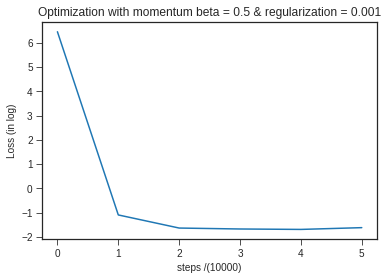

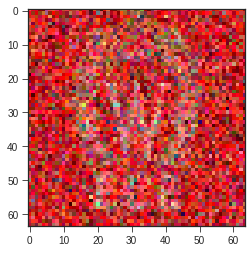

8 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.847e+06} |··················································| 0.0%
{cost = 4.666e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.063e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.515e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.173e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.410e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

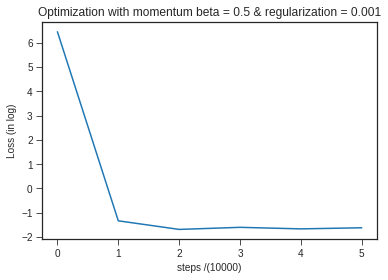

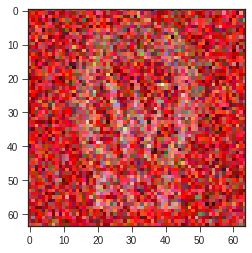

9 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 4.774e-02} |>>>>>>>>>>········································| 20.0%
{cost = 2.833e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.605e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.609e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.038e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

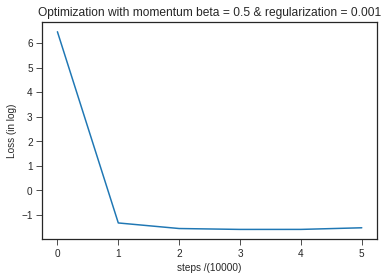

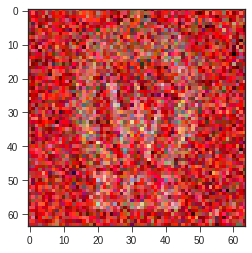

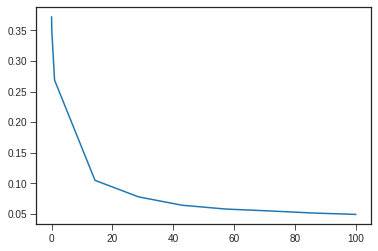

In [13]:
## cs recons

for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_reconstruct(r,c,measure_cs[:,:,time_index], upload_DMD_basis = mask_cs,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 1e-3, plot_step= 10000, max_epoch = 50000);
    '''pmt.PMT_reconstruct(r,c,cs_no_noise[:,:,time_index], upload_DMD_basis = mask_cs,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 0e-6, plot_step= 20000, max_epoch = 100000);'''
    #plt.figure();
    #plt.plot(pmt.W[:,0]);
    #plt.show();
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    Error_cs[time_index] = this_error;
plt.figure();
plt.plot(time,Error_cs); 
plt.show();

0 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 4.265e+06} |··················································| 0.0%
{cost = 2.344e+03} |>>>>>>>>>>········································| 20.0%
{cost = 1.921e+03} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.937e+03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.676e+03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.593e+03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

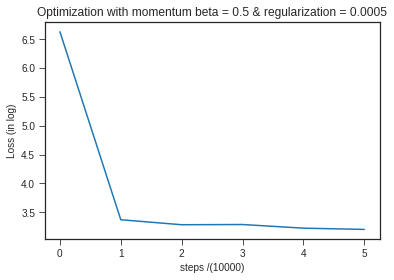

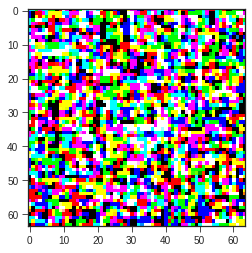

1 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.950e+06} |··················································| 0.0%
{cost = 4.152e+02} |>>>>>>>>>>········································| 20.0%
{cost = 3.652e+02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.464e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.364e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.427e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

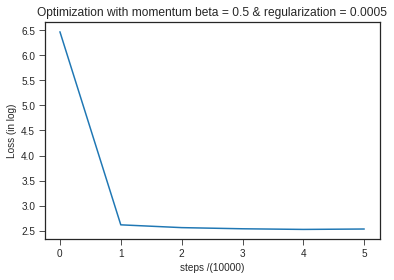

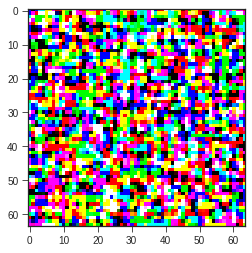

2 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.867e+06} |··················································| 0.0%
{cost = 1.318e+01} |>>>>>>>>>>········································| 20.0%
{cost = 1.295e+01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.218e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.162e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 9.860e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

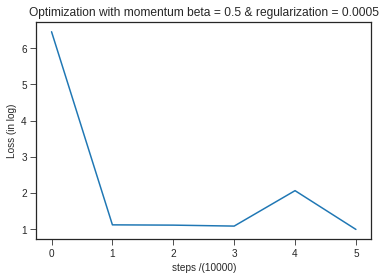

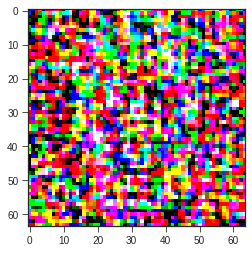

3 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 9.368e-01} |>>>>>>>>>>········································| 20.0%
{cost = 8.445e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 7.717e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 8.526e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 6.680e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

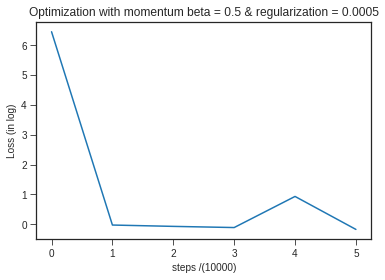

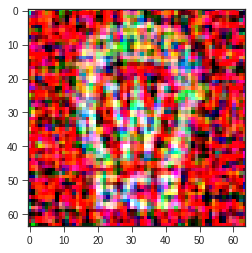

4 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.845e+06} |··················································| 0.0%
{cost = 1.289e+00} |>>>>>>>>>>········································| 20.0%
{cost = 1.260e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.777e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.072e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.066e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

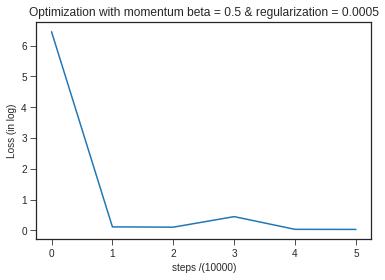

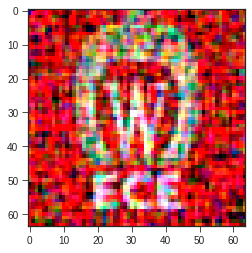

5 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 2.271e-01} |>>>>>>>>>>········································| 20.0%
{cost = 1.778e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.624e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.651e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.585e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

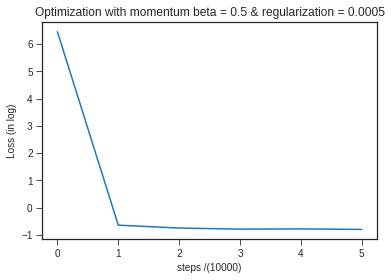

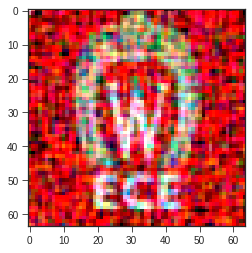

6 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.849e+06} |··················································| 0.0%
{cost = 5.243e-01} |>>>>>>>>>>········································| 20.0%
{cost = 4.577e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 4.467e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 4.064e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.999e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

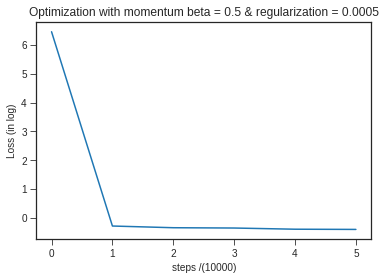

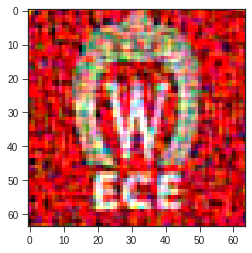

7 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.848e+06} |··················································| 0.0%
{cost = 1.238e-01} |>>>>>>>>>>········································| 20.0%
{cost = 8.040e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 7.880e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 5.339e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.378e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

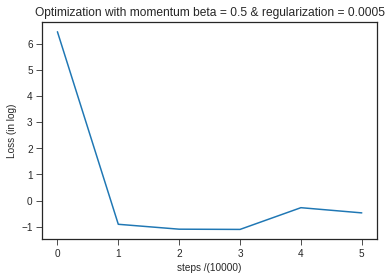

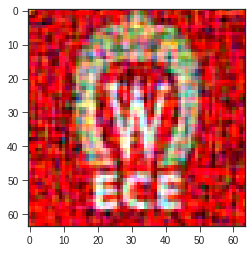

8 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.850e+06} |··················································| 0.0%
{cost = 4.183e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.585e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.358e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.257e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.143e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

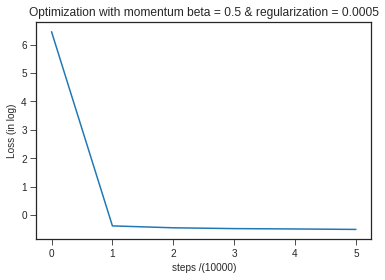

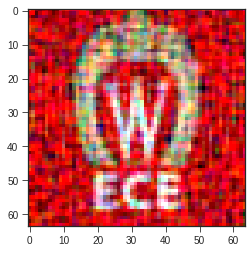

9 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 2.850e+06} |··················································| 0.0%
{cost = 4.654e-02} |>>>>>>>>>>········································| 20.0%
{cost = 1.833e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.726e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.591e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.616e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

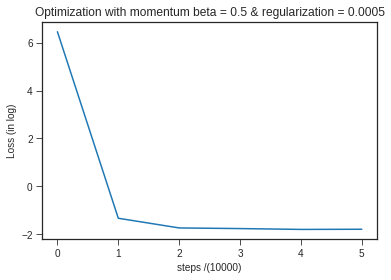

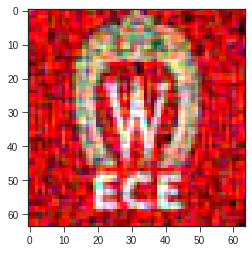

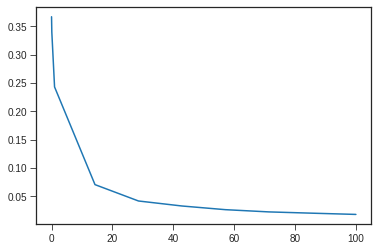

In [14]:
## hr recons
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_reconstruct(r,c,measure_hr[:,:,time_index], upload_DMD_basis = mask_hr,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 5e-4, plot_step= 10000, max_epoch = 50000);
    '''pmt.PMT_reconstruct(r,c,cs_no_noise[:,:,time_index], upload_DMD_basis = mask_cs,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 0e-6, plot_step= 20000, max_epoch = 100000);'''
    #plt.figure();
    #plt.plot(pmt.W[:,0]);
    #plt.show();
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    Error_hr[time_index] = this_error;
plt.figure();
plt.plot(time, Error_hr); 
plt.show();

0 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 3.424e+03} |··················································| 0.0%
{cost = 7.894e+01} |>>>>>>>>>>········································| 20.0%
{cost = 7.028e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 9.861e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 7.226e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 6.593e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

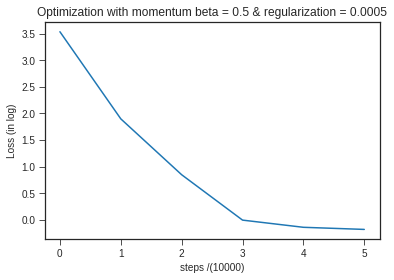

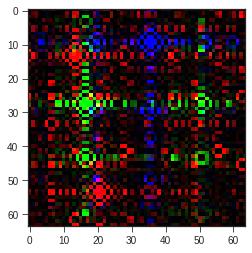

1 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 3.766e+02} |··················································| 0.0%
{cost = 3.354e+01} |>>>>>>>>>>········································| 20.0%
{cost = 7.899e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.326e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.916e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.514e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

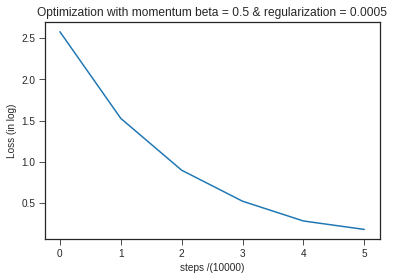

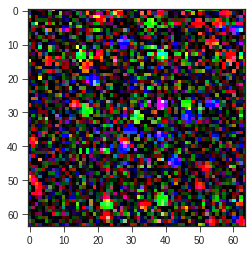

2 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 4.871e+01} |··················································| 0.0%
{cost = 5.361e+00} |>>>>>>>>>>········································| 20.0%
{cost = 1.775e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.109e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 8.949e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 8.019e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

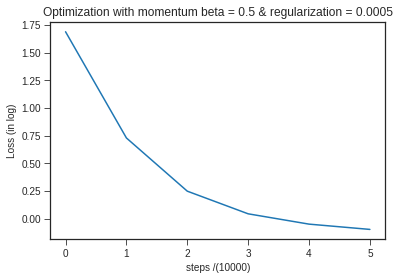

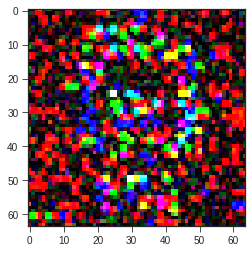

3 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 1.267e+01} |··················································| 0.0%
{cost = 1.378e+00} |>>>>>>>>>>········································| 20.0%
{cost = 5.864e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 4.762e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 4.419e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 4.280e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

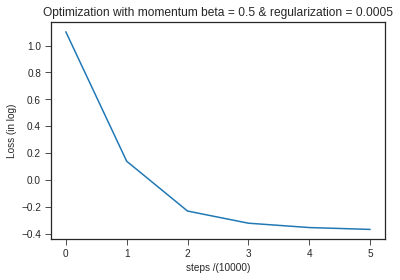

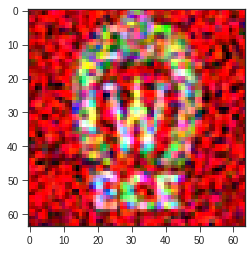

4 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 1.179e+01} |··················································| 0.0%
{cost = 1.138e+00} |>>>>>>>>>>········································| 20.0%
{cost = 4.705e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.900e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.668e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.577e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

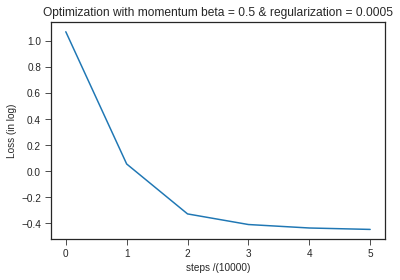

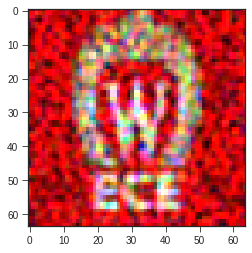

5 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 1.105e+01} |··················································| 0.0%
{cost = 9.956e-01} |>>>>>>>>>>········································| 20.0%
{cost = 4.075e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.421e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 3.228e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.189e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

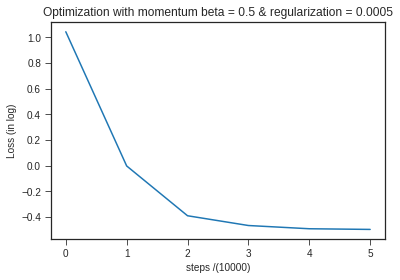

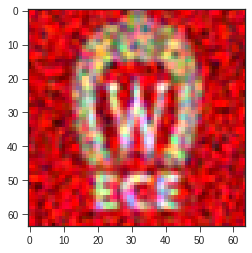

6 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 1.097e+01} |··················································| 0.0%
{cost = 9.778e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.772e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.092e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.959e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.907e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

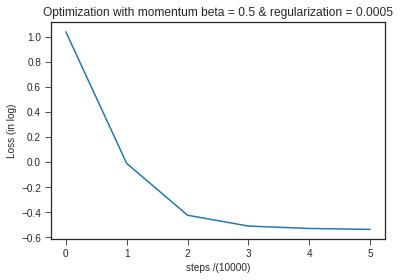

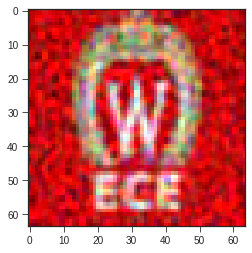

7 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 1.073e+01} |··················································| 0.0%
{cost = 9.381e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.623e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.994e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.873e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.793e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

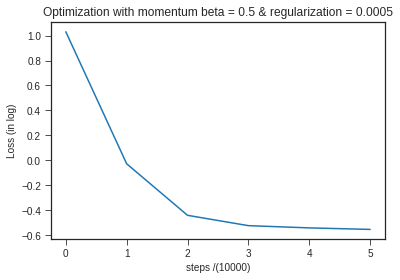

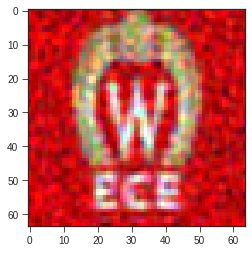

8 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 1.067e+01} |··················································| 0.0%
{cost = 9.143e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.520e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.892e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.781e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.727e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

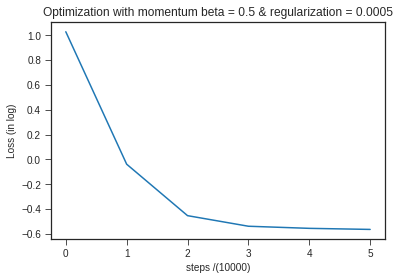

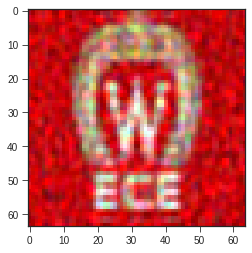

9 / 10
Mini-batch (size 10) Gradient Ascent!

{cost = 1.077e+01} |··················································| 0.0%
{cost = 9.031e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.363e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.743e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.637e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.594e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

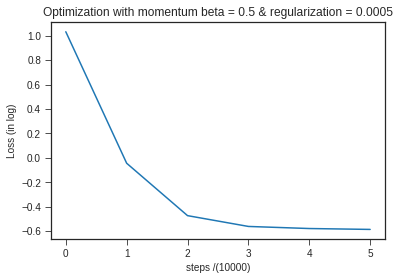

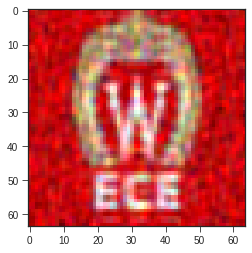

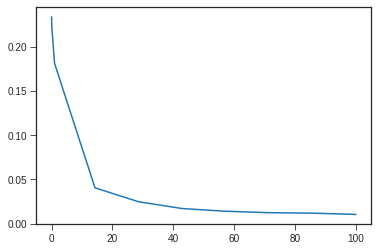

In [15]:
## hyper raster recons
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_reconstruct(r,c,measure_hr2[:,:,time_index], upload_DMD_basis = mask_hr2,
                        user_evaluation = False, learning_rate = 5e-2,
                        regularization = 5e-4, plot_step= 10000, max_epoch = 50000);
    '''pmt.PMT_reconstruct(r,c,cs_no_noise[:,:,time_index], upload_DMD_basis = mask_cs,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 0e-6, plot_step= 20000, max_epoch = 100000);'''
    #plt.figure();
    #plt.plot(pmt.W[:,0]);
    #plt.show();
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    Error_hr2[time_index] = this_error;
plt.figure();
plt.plot(time, Error_hr2);
plt.show();

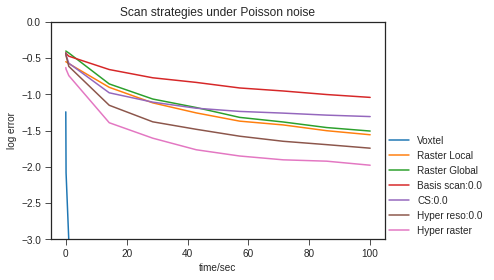

In [16]:
plt.figure();
plt.plot(time, np.log10(Error_voxtel), label = "Voxtel")
plt.plot(time, np.log10(Error_raster_local), label = "Raster Local");
plt.plot(time, np.log10(Error_raster_global), label = "Raster Global");
plt.plot(time, np.log10(Error_basis), label = "Basis scan:"+str(ratio_val));
plt.plot(time, np.log10(Error_cs), label = "CS:" +str(ratio_val));
plt.plot(time, np.log10(Error_hr), label = "Hyper reso:"+str(ratio_val));
#plt.plot(time, np.log10(Error_hr_Haar), label = "Hyper reso + Haar basis");
plt.plot(time, np.log10(Error_hr2), label = "Hyper raster");
plt.xlabel("time/sec");
plt.ylabel("log error");
plt.ylim(-3,-0.)
plt.title("Scan strategies under Poisson noise")
plt.legend(loc=[1,0]);
plt.show();

In [17]:
print("Raster local: The photons per mask per pixel is %.3e"%(light_level_raster_local));
print("Raster global: The photons per mask per pixel is %.3e"%(light_level_raster_global));
print("Basis scan: The photons per mask per pixel is %.3e"%(light_level_basis));
print("CS: The photons per mask per pixel for is %.3e"%(light_level_cs));
print("Hyper reso: The photons per mask per pixel for is %.3e"%(light_level_hr));
print("Hyper raster: The photons per mask per pixel for  is %.3e"%(light_level_hr2));

Raster local: The photons per mask per pixel is 9.766e+00
Raster global: The photons per mask per pixel is 5.960e+00
Basis scan: The photons per mask per pixel is 5.960e+00
CS: The photons per mask per pixel for is 1.988e+01
Hyper reso: The photons per mask per pixel for is 1.988e+01
Hyper raster: The photons per mask per pixel for  is 9.766e+00
